In [2]:
import os
import torch
import uproot
import glob
import torchvision
import numpy as np
from collections import OrderedDict
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

from torch.utils.data import Dataset, DataLoader
print(uproot.__version__) # Need latest uproot v3.7.1 for LazzyArrays

3.7.2


## A class for load in data from ROOT file, using uproot

It should be generic for all kind of flattree
LazzyArrays is very new for uproot. Need more testing for performances

In [3]:

class P2L1NTP(Dataset):
    def __init__(self, dir_name, features = None,
                 tree_name="l1PhaseIITree/L1PhaseIITree",
                 sequence_length=50, verbose=False):
        self.tree_name = tree_name
        self.features = features
        self.sequence_length = sequence_length
        self.file_names = glob.glob(dir_name)
        ## Cache will be needed in case we train with >1 eposh
        ## Having issue and reported in https://github.com/scikit-hep/uproot/issues/296
        self.cache = uproot.cache.ArrayCache(1024**3)
        self.upTree = uproot.lazyarrays(self.file_names, self.tree_name, self.features.keys(), cache=self.cache)/10
        #self.upTree = uproot.lazyarrays(self.file_names, self.tree_name, self.features.keys())
        
    def __len__(self):
        return uproot.numentries(self.file_names, self.tree_name, total=True)
    
    def __getitem__(self, idx):
        reflatnp = []
        event = self.upTree[idx]
        for b, ln in self.features.items():
            g  = event[b]
            if isinstance(g,float) == True:
                tg = np.array([g])
            else:
                if len(g)>= ln:
                    tg = g[:ln]
                else:
                    tg = np.pad(g, (0, ln-len(g)), 'constant', constant_values=0)
            reflatnp.append(tg)
        
        return np.concatenate(reflatnp, axis=0)
        ## If inputs are same length, reshape
        #return np.vstack(reflatnp).reshape((-1,),order='F')
        
        
        
        
        

## Set input files

physics object as a map of variables name in the root file and the expected number of objects.

Class will truncate or pad with 0 to the expected length

In [54]:
bg_files = "/uscms_data/d2/lpctrig/benwu/AutoEncoderSample/Phaes2L1Ntuple/NeutrinoGun_E_10GeV_V7_5_2_MERGED.root"
sg_files = "/uscms_data/d2/lpctrig/benwu/AutoEncoderSample/Phaes2L1Ntuple/VBF_HToInvisible_M125_14TeV_pythia8_PU200_V7_4_2.root"
sg_files2 =  "/uscms_data/d2/lpctrig/benwu/AutoEncoderSample/Phaes2L1Ntuple/VBFHToBB_M-125_14TeV_powheg_pythia8_weightfix_V_7_5_2.root"
sg_files3 = "/uscms_data/d2/lpctrig/benwu/AutoEncoderSample/Phaes2L1Ntuple/GluGluToHHTo4B_node_SM_14TeV-madgraph_V7_5_2.root"
PhysicsObt = OrderedDict(
    {
    #"jetEt" : 12,
    #"jetEta" : 12,
    #"jetPhi" : 12,
    #"tauEt" : 12,
    #"tauEta" : 12,
    #"tauPhi" : 12,
    #"caloJetEt" : 20,            # this line and below have non-uniform input across array
    #"caloJetEta" : 20,
    #"caloJetPhi" : 20,
    #"globalMuonPt": 1,
    #"globalMuonEta": 1,
    #"globalMuonPhi": 1,
    "puppiMETEt" : 1,
    "puppiMETPhi" : 1,
    #"tkCaloJetEt" : 10,
    #"tkCaloJetEta" : 10,
    #"tkCaloJetPhi" : 10,
    #"trackerJetEt" : 10,
    #"trackerJetEta" : 10,
    #"trackerJetPhi" : 10,
    #"tkElectronEt" : 1,
    #"tkElectronEta" : 1,
    #"tkElectronPhi" : 1,
    "puppiJetEt" : 5,
    "puppiJetEta" : 5,
    "puppiJetPhi" : 5,
    #"pfCandEt" : 25,
    #"pfCandEta" : 25,
    #"pfCandPhi" : 25,
    #"tkMuonPt" : 1,
    #"tkMuonEta" : 1,
    #"tkMuonPhi" : 1,
}
)

bg = P2L1NTP(sg_files, PhysicsObt)
gg = bg[0]
print(gg.dtype)

# try
file = uproot.open(sg_files3)
#file.keys()
file1 = file['l1PhaseIITree']
file2=file1['L1PhaseIITree']


#271 physobj/para > 499100 events > 12 particles      

float64


In [55]:
import time
start = time.time()
num_epochs = 3
batch_size = 150 #144
learning_rate = 1e-3

dataloader = DataLoader(bg, batch_size=batch_size, pin_memory=True, shuffle=False)


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(17, 12),#144,1280
            nn.LeakyReLU(True),
            nn.Linear(12, 6), # 1280,64
            #nn.LeakyReLU(True), 
            #nn.Linear(64, 12), #64,12
            #nn.ReLU(True), 
            #nn.Linear(25, 12),
            nn.LeakyReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),
            nn.LeakyReLU(True),
            nn.Linear(12, 17),
            #nn.LeakyReLU(True),
            #nn.Linear(64, 98),
            #nn.ReLU(True), 
            #nn.Linear(50, 75), 
            nn.LeakyReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = autoencoder()
if torch.cuda.is_available():
    model = model.cuda()
criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.3,
                              patience=3,
                              verbose=1,
                              threshold=1e-4,
                              cooldown=2,
                              min_lr=1e-7
                             )    


train_frac = 0.8
for epoch in range(num_epochs):
    val_loss = []
    for batch_idx, bg_data in enumerate(dataloader):
        
        _bg_img = Variable(bg_data.type(torch.FloatTensor))
        if torch.cuda.is_available():
            _bg_img = _bg_img.cuda()
        if batch_idx < (len(dataloader)*0.8):
            # ===================forward=====================
            out = model(_bg_img)
            loss = criterion(out, _bg_img)
            bg_data = bg_data.numpy()
            _bg_out = out.cpu().detach().numpy()
            _bg_loss = loss.cpu().detach().numpy()
            if batch_idx == 0:
                bg_out = _bg_out
                bg_loss = _bg_loss
                bg_img = bg_data
            
            else:
                bg_loss = np.append([bg_loss],[_bg_loss])
                bg_out = np.concatenate((bg_out,_bg_out))
                bg_img = np.concatenate((bg_img,bg_data))
        
            # ===================backward====================
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            # =================validation===================
        else:
            
            val_out = model(_bg_img)
            _val_loss = criterion(val_out, _bg_img)
            _val_loss = _val_loss.cpu().detach().numpy()
            val_loss.append(_val_loss)
        
        
        # ===================log========================
    
    print('epoch [{}/{}], loss:{:.4f},val_loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data[0],(np.sum(val_loss)/len(val_loss))))
    scheduler.step(loss)
torch.save(model.state_dict(), './sim_autoencoder.pth')

print(bg_loss.shape, bg_out.shape, bg_img.shape)
end=time.time()
print('{} mins'.format((end-start)/60))



/cvmfs/cms-lpc.opensciencegrid.org/sl7/gpu/anaconda3/envs/mlenv0/lib/python3.6/site-packages/ipykernel_launcher.py:100: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


epoch [1/3], loss:0.2905,val_loss:0.3018
epoch [2/3], loss:0.1217,val_loss:0.1215
epoch [3/3], loss:0.0535,val_loss:0.0569
(228,) (34200, 17) (34200, 17)
0.8911312063535054 mins


In [56]:
bg_img = bg_img*10
bg_out = bg_out*10

1.0

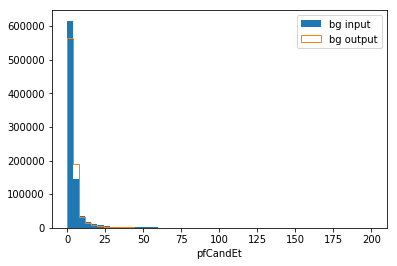

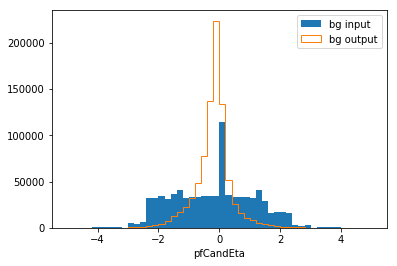

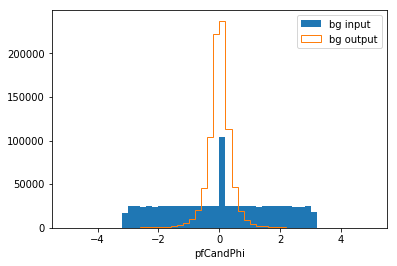

In [51]:
import matplotlib.pyplot as plt

plt.hist(bg_img[:,0:25].flatten(), bins=50, range=(0,200), label='bg input')
plt.hist(bg_out[:,0:25].flatten(), histtype='step',bins=50,range=(0,200),label='bg output')
plt.legend(loc='best')
plt.xlabel('pfCandEt')
plt.show()

plt.hist(bg_img[:,25:50].flatten(), bins=50, range=(-5,5), label='bg input')
plt.hist(bg_out[:,25:50].flatten(), histtype='step',bins=50,range=(-5,5),label='bg output')
plt.legend(loc='best')
plt.xlabel('pfCandEta')
plt.show()

plt.hist(bg_img[:,50:].flatten(), bins=50, range=(-5,5), label='bg input')
plt.hist(bg_out[:,50:].flatten(), histtype='step',bins=50,range=(-5,5),label='bg output')
plt.legend(loc='best')
plt.xlabel('pfCandPhi')
plt.show()

## Testing cells below



In [57]:
# H to Invisible
new_batch_size = 300
sg = P2L1NTP(sg_files, PhysicsObt)
sg_dataloader = DataLoader(sg, batch_size=new_batch_size, pin_memory=True, shuffle=False)

model = autoencoder()
for batch_idx, sg_data in enumerate(sg_dataloader):
    
    _sg_img = Variable(sg_data.type(torch.FloatTensor))
    _sg_out = model(_sg_img)
    _sg_loss = criterion(_sg_out, _sg_img)
    sg_data = sg_data.numpy()
    _sg_out = _sg_out.detach().numpy()
    _sg_loss = _sg_loss.detach().numpy()
    if batch_idx == 0:
        sg_out = _sg_out
        sg_loss = _sg_loss
        sg_img = sg_data
    
    else:
        sg_loss = np.append([sg_loss],[_sg_loss])
        sg_out = np.concatenate((sg_out,_sg_out))
        sg_img = np.concatenate((sg_img,sg_data))
    

print(sg_loss.shape)

    

(143,)


In [28]:
# VBFH to BB
new_batch_size = 300
sg2 = P2L1NTP(sg_files2, PhysicsObt)
sg2_dataloader = DataLoader(sg2, batch_size=new_batch_size, pin_memory=True, shuffle=False)

model = autoencoder()
for batch_idx, sg2_data in enumerate(sg2_dataloader):
    
    _sg2_img = Variable(sg2_data.type(torch.FloatTensor))
    _sg2_out = model(_sg2_img)
    _sg2_loss = criterion(_sg2_out, _sg2_img)
    sg2_data = sg2_data.numpy()
    _sg2_out = _sg2_out.detach().numpy()
    _sg2_loss = _sg2_loss.detach().numpy()
    if batch_idx == 0:
        sg2_out = _sg2_out
        sg2_loss = _sg2_loss
        sg2_img = sg2_data
    
    else:
        sg2_loss = np.append([sg2_loss],[_sg2_loss])
        sg2_out = np.concatenate((sg2_out,_sg2_out))
        sg2_img = np.concatenate((sg2_img,sg2_data))
    

print(sg2_loss.shape)

(290,)


In [29]:
# GluGlu to HH to 4B
new_batch_size = 300
sg3 = P2L1NTP(sg_files3, PhysicsObt)
sg3_dataloader = DataLoader(sg3, batch_size=new_batch_size, pin_memory=True, shuffle=False)

model = autoencoder()
for batch_idx, sg3_data in enumerate(sg3_dataloader):
    
    _sg3_img = Variable(sg3_data.type(torch.FloatTensor))
    _sg3_out = model(_sg3_img)
    _sg3_loss = criterion(_sg3_out, _sg3_img)
    sg3_data = sg3_data.numpy()
    _sg3_out = _sg3_out.detach().numpy()
    _sg3_loss = _sg3_loss.detach().numpy()
    if batch_idx == 0:
        sg3_out = _sg3_out
        sg3_loss = _sg3_loss
        sg3_img = sg3_data
    
    else:
        sg3_loss = np.append([sg3_loss],[_sg3_loss])
        sg3_out = np.concatenate((sg3_out,_sg3_out))
        sg3_img = np.concatenate((sg3_img,sg3_data))
    

print(sg2_loss.shape)

(290,)


In [47]:
sg_img = sg_img*10
sg_out = sg_out*10
sg2_img = sg2_img*10
sg2_out = sg2_out*10
sg3_img = sg3_img*10
sg3_out = sg3_out*10

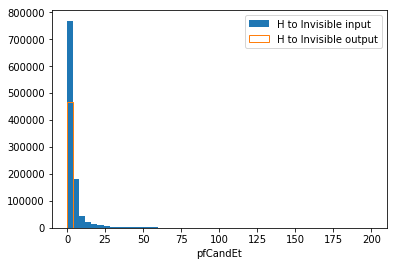

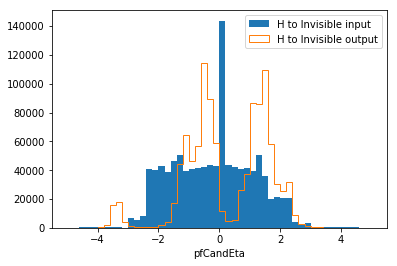

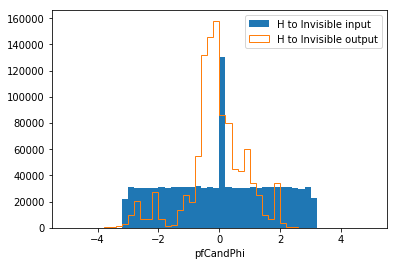

In [52]:
plt.hist(sg_img[:,0:25].flatten(), bins=50, range=(0,200), label='H to Invisible input')
plt.hist(sg_out[:,0:25].flatten(), histtype='step',bins=50,range=(0,200),label='H to Invisible output')
plt.legend(loc='best')
plt.xlabel('pfCandEt')
plt.show()

plt.hist(sg_img[:,25:50].flatten(), bins=50, range=(-5,5), label='H to Invisible input')
plt.hist(sg_out[:,25:50].flatten(), histtype='step',bins=50,range=(-5,5),label='H to Invisible output')
plt.legend(loc='best')
plt.xlabel('pfCandEta')
plt.show()

plt.hist(sg_img[:,50:].flatten(), bins=50, range=(-5,5), label='H to Invisible input')
plt.hist(sg_out[:,50:].flatten(), histtype='step',bins=50,range=(-5,5),label='H to Invisible output')
plt.legend(loc='best')
plt.xlabel('pfCandPhi')
plt.show()

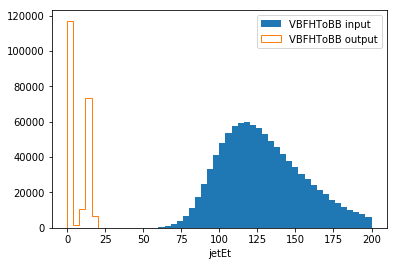

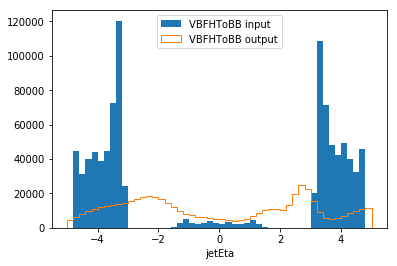

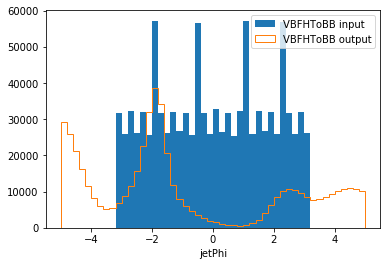

In [32]:
plt.hist(sg2_img[:,0:12].flatten(), bins=50, range=(0,200), label='VBFHToBB input')
plt.hist(sg2_out[:,0:12].flatten(), histtype='step',bins=50,range=(0,200),label='VBFHToBB output')
plt.legend(loc='best')
plt.xlabel('jetEt')
plt.show()

plt.hist(sg2_img[:,12:24].flatten(), bins=50, range=(-5,5), label='VBFHToBB input')
plt.hist(sg2_out[:,12:24].flatten(), histtype='step',bins=50,range=(-5,5),label='VBFHToBB output')
plt.legend(loc='best')
plt.xlabel('jetEta')
plt.show()

plt.hist(sg2_img[:,24:].flatten(), bins=50, range=(-5,5), label='VBFHToBB input')
plt.hist(sg2_out[:,24:].flatten(), histtype='step',bins=50,range=(-5,5),label='VBFHToBB output')
plt.legend(loc='best')
plt.xlabel('jetPhi')
plt.show()

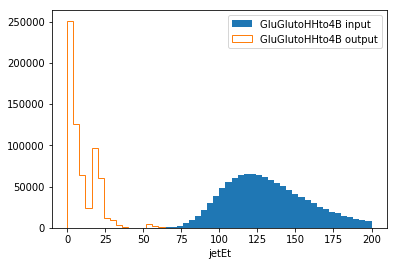

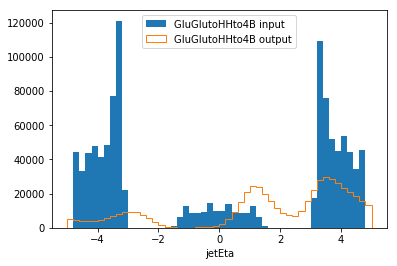

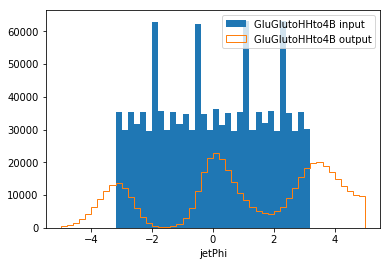

In [33]:
plt.hist(sg3_img[:,0:12].flatten(), bins=50, range=(0,200), label='GluGlutoHHto4B input')
plt.hist(sg3_out[:,0:12].flatten(), histtype='step',bins=50,range=(0,200),label='GluGlutoHHto4B output')
plt.legend(loc='best')
plt.xlabel('jetEt')
plt.show()

plt.hist(sg3_img[:,12:24].flatten(), bins=50, range=(-5,5), label='GluGlutoHHto4B input')
plt.hist(sg3_out[:,12:24].flatten(), histtype='step',bins=50,range=(-5,5),label='GluGlutoHHto4B output')
plt.legend(loc='best')
plt.xlabel('jetEta')
plt.show()

plt.hist(sg3_img[:,24:].flatten(), bins=50, range=(-5,5), label='GluGlutoHHto4B input')
plt.hist(sg3_out[:,24:].flatten(), histtype='step',bins=50,range=(-5,5),label='GluGlutoHHto4B output')
plt.legend(loc='best')
plt.xlabel('jetPhi')
plt.show()

Text(0.5, 0, 'Reconstruction Loss')

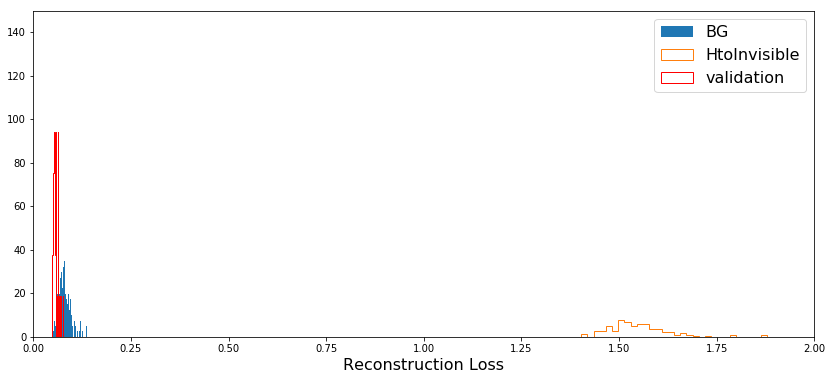

In [59]:
plt.figure(figsize=(14,6))
plt.hist(bg_loss,bins=50,label='BG', normed=True)
plt.hist(sg_loss,bins=50,label='HtoInvisible', histtype='step', normed=True)
#plt.hist(sg2_loss,bins=20,label='VBFHToBB', histtype='step',color='green', normed=True)
#plt.hist(sg3_loss,bins=20,label='GluGlutoHHto4B', histtype='step',color='purple', normed=True)
plt.hist(val_loss,bins=30,label='validation',histtype="step",color='red', normed=True)
plt.legend(loc='best',fontsize=16)
plt.ylim(0,150)
plt.xlim(0,2)
plt.xlabel('Reconstruction Loss', fontsize=16)


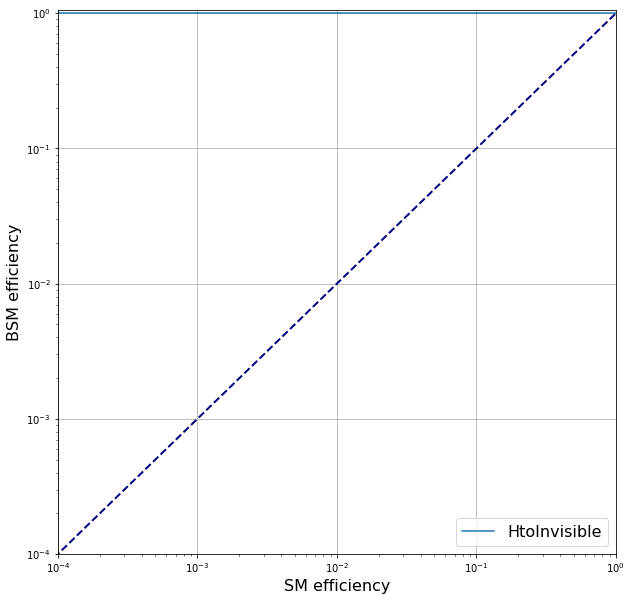

In [60]:
p_SM = np.logspace(base=10, start=-5, stop=0, num=100)
p_SM[-1] = 0.999

f_ROC, ax_arr_ROC = plt.subplots(1,1, figsize=(10,10))
ax_arr_ROC.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

ax_arr_ROC.set_xlim([1e-4, 1])
ax_arr_ROC.set_ylim([1e-4, 1.05])
ax_arr_ROC.set_xlabel('SM efficiency', fontdict={'size': 16})
ax_arr_ROC.ticklabel_format()
ax_arr_ROC.set_ylabel('BSM efficiency', fontdict={'size': 16})
ax_arr_ROC.set_yscale('log')
ax_arr_ROC.set_xscale('log')
ax_arr_ROC.grid()

bg_sort = np.argsort(bg_loss)
bg_re_loss = bg_loss[bg_sort]

# Find out the sm threshold values corresponding to each percentile in p_SM
frac = np.cumsum(np.ones_like(bg_re_loss)/len(bg_re_loss)) # an array of fraction (1/n, 2/n, etc.)

indices_of_thresholds = np.argmax(frac > np.atleast_2d(1-p_SM).T, axis=1) # which element closest to each value in p_SM
bg_thresholds = bg_re_loss[indices_of_thresholds] # what are the corresponding threshold values


sg_frac = np.float64(np.sum(sg_loss > np.atleast_2d(bg_thresholds).T, axis=1, dtype=np.float128)/len(sg_loss))

#sg2_frac = np.float64(np.sum(sg2_loss > np.atleast_2d(bg_thresholds).T, axis=1, dtype=np.float128)/len(sg2_loss))

#sg3_frac = np.float64(np.sum(sg3_loss > np.atleast_2d(bg_thresholds).T, axis=1, dtype=np.float128)/len(sg3_loss))

ax_arr_ROC.plot(p_SM,sg_frac,label='HtoInvisible')
#ax_arr_ROC.plot(p_SM,sg2_frac,label='VBFHToBB')
#ax_arr_ROC.plot(p_SM,sg3_frac,label='GluGlutoHHto4B')


ax_arr_ROC.legend(loc="lower right", fontsize=16)




2

In [6]:
bg_files = "/uscms_data/d2/lpctrig/benwu/AutoEncoderSample/Phaes2L1Ntuple/NeutrinoGun_E_10GeV_V7_5_2_MERGED.root"
nocache_data = uproot.lazyarrays(bg_files, "l1PhaseIITree/L1PhaseIITree", PhysicsObt.keys(), entrysteps=100)
cache = uproot.cache.ArrayCache(1024**3)
data = uproot.lazyarrays(bg_files, "l1PhaseIITree/L1PhaseIITree",PhysicsObt.keys(), entrysteps=100,cache=cache)/200



20


### In case you don't have uproot, you can use my local copy in LPC

Or, just "pip3 install uproot"

In [ ]:
import sys
sys.path.insert(0, "/uscms/home/benwu/.local/lib/python3.6/site-packages/")
print(sys.path)

In [10]:
# Shuffle by indexing instead of copies. 
def random_dataloaders(dataset, train_frac, valid_frac, batch_size):
    # Split training into train and validation
    indices = torch.randperm(len(dataset))
    train_indices = indices[:len(indices)*valid_frac]
    valid_indices = indices[len(indices)*valid_frac:]

    train_loader = torch.utils.data.DataLoader(train_set, pin_memory=True, batch_size=batch_size,
                                               sampler=SubsetRandomSampler(train_indices))
    valid_loader = torch.utils.data.DataLoader(valid_set, pin_memory=True, batch_size=batch_size,
                                               sampler=SubsetRandomSampler(valid_indices))

    return train_loader, valid_loader